In [1]:
# Import libraries
from __future__ import print_function


import numpy as np
import pandas as pd
import psycopg2
import os
import getpass

from collections import OrderedDict

# path to output data files to - can be relative to the current folder
data_path = 'data'

In [2]:
psycopg2.__version__

'2.9.9 (dt dec pq3 ext lo64)'

In [3]:
# colours for prettier plots
import matplotlib
import matplotlib.pyplot as plt
import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples

marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

# plot settings
%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 20}
matplotlib.rc('font', **font)

In [4]:
# helper function for generating tables
# this rolls back the cursor if it fails
def execute_query_safely(sql, con):
    cur = con.cursor()
    
    # try to execute the query
    try:
        cur.execute(sql)
    except:
        # if an exception, rollback, rethrow the exception - finally closes the connection
        cur.execute('rollback;')
        raise
    finally:
        cur.close()
    
    return

In [5]:
sqluser = getpass.getuser()
print('Using username {}'.format(sqluser))

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

Using username maba4574


In [6]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

print('Connected to postgres {}.{}.{}!'.format(int(con.server_version/10000),
                                              (con.server_version - int(con.server_version/10000)*10000)/100,
                                              (con.server_version - int(con.server_version/100)*100)))

Connected to postgres 15.0.04.4!


In [7]:
# check if the sepsis3_cohort table exists ... if not we must generate it
query = """
SELECT EXISTS(SELECT 1 FROM information_schema.tables 
              WHERE table_catalog = '{}'
              AND table_schema in ('public','{}')
              AND table_name = 'sepsis3');
""".format(dbname, schema_name)
tbl_exists = pd.read_sql_query(query, con)
tbl_exists = tbl_exists.loc[0,'exists']
if tbl_exists:
    print('Found the `sepsis3` table. Skipping generation of data in SQL.')
else:
    print('Running SQL code to generate tables. This may take some time.')
    
    # read through the "make-tables.sql" file in the sql subfolder
    query_path = 'query'
    
    with open(os.path.join(query_path, 'make-tables.sql'), 'r') as fp:
        for line in fp.readlines():
            if len(line)<2:
                print(line,end='')
                continue
            
            if line[0:2] != '\i':
                print(line,end='')
                continue
                
            # lines which begin with '\i' call SQL files that generate tables
            query_file = os.path.join(query_path, line[3:].replace('\n',''))
            print('Running {} ...'.format(query_file), end=' ')
            with open(query_file, 'r') as fp_query:
                query = ''.join(fp_query.readlines())
            execute_query_safely(query_schema + query, con)
            print('done.')

/var/folders/z8/9rzhj2td0kvbgshc9wpwwtv00000gp/T/ipykernel_43009/835220276.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tbl_exists = pd.read_sql_query(query, con)


Running SQL code to generate tables. This may take some time.
-- As the script is generating many tables, it may take some time.

-- We assume the database and the search path are set correctly.
-- You can set the search path as follows:
-- SET SEARCH_PATH TO public,mimiciii;
-- This will create tables on public and read tables from mimiciii

BEGIN;
-- ----------------------------- --
-- ---------- STAGE 1 ---------- --
-- ----------------------------- --


Running query/tbls/abx-poe-list.sql ... done.
Running query/tbls/abx-micro-prescription.sql ... done.
Running query/tbls/suspicion-of-infection.sql ... done.

-- blood cultures around ICU admission
-- generate cohort
Running query/tbls/cohort.sql ... done.




Running query/../mimic-code/concepts/comorbidity/elixhauser_quan.sql ... done.

COMMIT;


In [10]:
# query = query_schema + "select * from elixhauser_quan"
# com = pd.read_sql_query(query,con)
# com 
# com.to_csv(os.path.join(data_path, 'elixhauser_quan.csv'),sep=',',index=False)

In [133]:
## generate vasopressor doses

# read through the "make-tables-vasopressor_doses.sql" file in the sql subfolder
query_path = 'query'

with open(os.path.join(query_path, 'make-tables-vasopressor_doses.sql'), 'r') as fp:
    for line in fp.readlines():
        if len(line)<2:
            print(line,end='')
            continue
        
        if line[0:2] != '\i':
            print(line,end='')
            continue
            
        # lines which begin with '\i' call SQL files that generate tables
        query_file = os.path.join(query_path, line[3:].replace('\n',''))
        print('Running {} ...'.format(query_file), end=' ')
        with open(query_file, 'r') as fp_query:
            query = ''.join(fp_query.readlines())
        execute_query_safely(query_schema + query, con)
        print('done.')

-- As the script is generating many tables, it may take some time.

-- We extract the vasopressor doses for all patients in the ICU
-- Needs later preprocessing to bring the tables together and select the appropriate cohort

BEGIN;


Running query/../mimic-code/concepts/durations/weight_durations.sql ... done.

Running query/../mimic-code/concepts/durations/dobutamine_dose.sql ... done.
Running query/../mimic-code/concepts/durations/dopamine_dose.sql ... done.
Running query/../mimic-code/concepts/durations/vasopressin_dose.sql ... done.
Running query/../mimic-code/concepts/durations/phenylephrine_dose.sql ... done.
Running query/../mimic-code/concepts/durations/epinephrine_dose.sql ... done.
Running query/../mimic-code/concepts/durations/norepinephrine_dose.sql ... done.





COMMIT;

In [132]:
## aggregated to ts 
## labs_first_day, fixed
## urine_output, fixed
## vitals_first_day, fixed

## already ts
## blood_gas_first_day
## blood_gas_first_day_arterial

## vasopressors only have duration in hours, we created new tables to extract the dosage, but it needs preprocessing


## static:
## comorbidities elix
## demographics

query = query_schema + "select * from sepsis3_cohort"
co = pd.read_sql_query(query,con)
co 

DatabaseError: Execution failed on sql 'SET search_path to public,mimiciii;select * from sepsis3_cohort': relation "sepsis3_cohort" does not exist
LINE 1: SET search_path to public,mimiciii;select * from sepsis3_coh...
                                                         ^


In [10]:
# exclusion criteria:
#   - less than 16 years old
#   - never have any chartevents data (i.e. likely administrative error)
#   - not cardiac surgery
#   - suspected of infection
#   - first ICU stay
#   - not a CareVue patient (i.e. admitted 2008-2012)
# these exclusion criteria are created in the sepsis3_cohort table
query = query_schema + "select * from sepsis3_cohort"
co = pd.read_sql_query(query,con)

In [11]:
co

,hadm_id,icustay_id,intime,outtime,age,gender,ethnicity,first_service,dbsource,suspected_of_infection_poe,...,positiveculture_poe,antibiotic_time_poe,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,excluded
0,152234,200001,2181-11-25 19:06:12,2181-11-28 20:59:25,61.0499,F,ASIAN - ASIAN INDIAN,MED,metavision,1,...,0.0,2181-11-19,1,0,0,0,1,0,0,1
1,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,48.2940,M,WHITE,SURG,carevue,1,...,1.0,2199-08-02,0,0,0,1,0,0,0,1
2,189514,200006,2159-09-03 11:28:14,2159-09-04 19:08:10,54.0710,M,OTHER,MED,carevue,0,...,NaN,NaT,1,0,0,1,0,0,0,1
3,129310,200007,2109-02-17 10:03:37,2109-02-18 17:03:12,43.3439,M,WHITE,CMED,carevue,0,...,NaN,NaT,0,0,0,1,0,0,0,1
4,129607,200009,2189-11-30 10:34:32,2189-12-02 14:17:37,47.5548,F,WHITE,CSURG,carevue,0,...,NaN,2189-11-30,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,169431,299993,2149-11-13 21:01:05,2149-11-16 16:57:30,26.2264,M,WHITE,SURG,carevue,0,...,NaN,NaT,0,0,0,1,0,0,0,1
61528,177406,299994,2114-12-09 11:56:00,2114-12-15 20:29:14,74.2165,F,WHITE,MED,carevue,1,...,0.0,2114-12-13,1,0,0,1,0,1,0,1
61529,134959,299995,2116-03-04 17:44:39,2116-03-06 18:03:55,23.3763,M,WHITE,NMED,carevue,1,...,0.0,2116-03-05,0,0,0,1,0,0,0,1
61530,158288,299998,2181-07-05 18:47:40,2181-07-07 17:24:38,86.9560,M,WHITE,GU,metavision,1,...,1.0,2181-07-05,0,0,0,0,0,0,0,0


# Exclusions - applied independently

In [12]:
# print out the exclusions
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))
idxRem = np.zeros(co.shape[0])
for c in co.columns:
    if c.startswith('exclusion_'):
        print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.mean(co[c])*100.0, c))
        idxRem[co[c].values==1] = 1
        
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

Cohort - initial size: 61532 ICU stays
  15056 (24.47%) - exclusion_secondarystay
   8109 (13.18%) - exclusion_nonadult
   7343 (11.93%) - exclusion_csurg
  37912 (61.61%) - exclusion_carevue
   7343 (11.93%) - exclusion_early_suspicion
   3914 (6.36%) - exclusion_late_suspicion
    491 (0.80%) - exclusion_bad_data
Final cohort size: 11791.0 ICU stays (19.16%).


# Exclusions - applied sequentially

In [13]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           'exclusion_early_suspicion', 'exclusion_late_suspicion', 'exclusion_bad_data']

idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
        
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

print()
# define idxRem to exclude non-metavision admissions initially
print('=============================')
print('====== METAVISION ONLY ======')
print(' Patients admitted 2008-2012 ')
print('=============================')
print()

idxRem = co['dbsource']!='metavision'
N = np.sum(~idxRem)
N_IGNORE = np.sum(idxRem)

# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(N))

for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/N, c))
    idxRem[co[c].values==1] = True
        
print('Final non-suspected cohort size: {}/{} ICU stays ({:2.2f}%).'.format(
        np.sum(~idxRem), N, np.sum(~idxRem)*100.0/N))
print('')

print('Of these patients...')
c='suspected_of_infection_poe'
N_REM = np.sum( (~idxRem) & (co[c].values==1) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

Cohort - initial size: 61532 ICU stays
   8109 (13.18%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
   5905 (9.60%) - exclusion_csurg
  18909 (30.73%) - exclusion_carevue
   1250 (2.03%) - exclusion_early_suspicion
    724 (1.18%) - exclusion_late_suspicion
     18 (0.03%) - exclusion_bad_data
Final non-suspected cohort size: 11791 ICU stays (19.16%).

====== METAVISION ONLY ======
 Patients admitted 2008-2012 

Cohort - initial size: 23620 ICU stays
      3 (0.01%) - exclusion_nonadult
   7536 (31.91%) - exclusion_secondarystay
   2298 (9.73%) - exclusion_csurg
      0 (0.00%) - exclusion_carevue
   1250 (5.29%) - exclusion_early_suspicion
    724 (3.07%) - exclusion_late_suspicion
     18 (0.08%) - exclusion_bad_data
Final non-suspected cohort size: 11791/23620 ICU stays (49.92%).

Of these patients...
   7061 (59.88%) - suspected_of_infection_poe


# Histogram of time of suspected infection

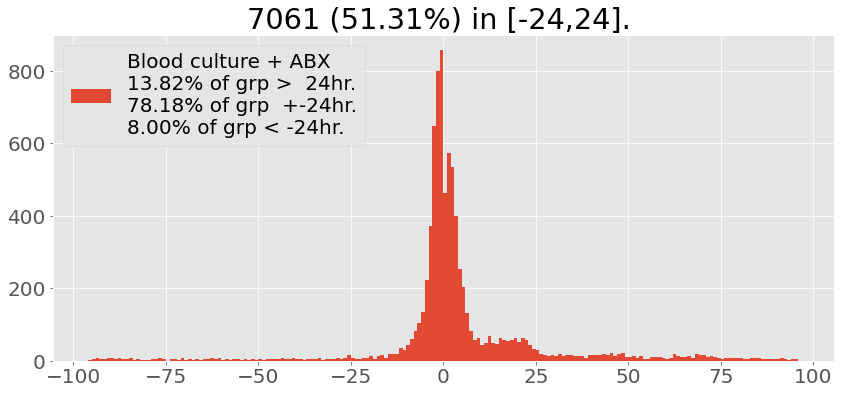

In [14]:
# generate exclusions *except* early/late suspicion
COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           #'exclusion_early_suspicion', 'exclusion_late_suspicion',
           'exclusion_bad_data']
idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    idxRem[co[c].values==1] = 1
    
idxRem = idxRem.astype(bool)

# distribution of time of infection
N_HR = 96
xi = np.linspace(-N_HR, N_HR, N_HR*2+1)
col = gg_color_hue(5)

pretty_dict = {'suspected_infection_time_poe_days': 'Blood culture + ABX'}
c = 'suspected_infection_time_poe_days'

idxKeep = ~co[c].isnull()
tmp = co.loc[~idxRem & idxKeep, c].values * 24.0
N_firstday = sum( (tmp>-24) & (tmp<24) )

lbl_str = pretty_dict[c]
lbl_str += '\n' + '{:2.2f}% of grp >  24hr.'.format(sum(tmp>24)*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of grp  +-24hr.'.format(sum((tmp>=-24) & (tmp<=24))*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of grp < -24hr.'.format(sum(tmp<-24)*100.0 / np.sum(~idxRem & idxKeep))

plt.figure(figsize=[14,6])
plt.hist( tmp, bins=xi, label=lbl_str)
plt.title('{} ({:2.2f}%) in [-24,24]. '.format(
        N_firstday, N_firstday*100.0 / np.sum(~idxRem)))
plt.legend(loc='upper left')
    
plt.show()

We can see that most patients are suspected of infection either before, or at the time of their ICU admission. This motivates the decision to evaluate the performance of the scores at ICU admission.

# Load final dataset from Postgres

In [15]:
# load in final dataset - note we apply the exclusion criteria with excluded=0
query = query_schema + "select * from sepsis3 where excluded = 0"

df = pd.read_sql_query(query,con)
df

,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,...,sepsis_cdc_simple,elixhauser_hospital,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score
0,200021,109307,0,2114-12-26 19:45:12,2114-12-27 22:46:28,metavision,NaT,NaN,None,NaN,...,0,0,1,4,7,3,3,1.0,1.0,1.0
1,200028,181955,0,2133-10-29 17:13:50,2133-11-01 14:55:14,metavision,NaT,NaN,None,NaN,...,0,0,1,10,6,3,2,1.0,0.0,1.0
2,200033,198650,0,2198-08-07 17:56:17,2198-08-21 14:59:18,metavision,2198-08-08 01:00:00,-0.294248,MRSA SCREEN,0.0,...,1,9,0,1,1,2,0,0.0,0.0,0.0
3,200061,121149,0,2134-01-23 16:38:46,2134-01-25 16:59:14,metavision,2134-01-24 00:30:00,-0.327245,BLOOD CULTURE,0.0,...,0,0,0,2,2,4,1,0.0,0.0,1.0
4,200075,132255,0,2159-09-23 00:13:20,2159-09-25 01:55:17,metavision,2159-09-23 03:33:00,-0.138657,MRSA SCREEN,0.0,...,1,0,1,8,4,3,2,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11786,299948,183226,0,2119-05-25 13:47:31,2119-05-27 12:31:54,metavision,2119-05-25 14:37:00,-0.034363,MRSA SCREEN,0.0,...,1,0,0,3,2,2,2,1.0,0.0,1.0
11787,299949,199962,0,2118-07-16 05:42:45,2118-07-20 14:46:25,metavision,2118-07-16 09:25:00,-0.154340,SWAB,0.0,...,0,0,1,3,2,2,0,0.0,0.0,0.0
11788,299950,110990,0,2122-06-20 13:25:29,2122-06-22 18:21:02,metavision,2122-06-20 00:00:00,0.559363,URINE,0.0,...,1,0,0,5,2,2,2,1.0,0.0,1.0
11789,299962,146497,0,2195-11-25 19:04:06,2195-11-26 13:21:12,metavision,NaT,NaN,None,NaN,...,0,0,0,5,6,2,2,1.0,0.0,1.0


We have: ICU intime/outtime, suspected infection time, whether the microbiology culture was positive, some demographics, comorbidities, outcomes, and the severity scores. 

The severity scores are extracted at a [0, 24] hour window centered around ICU admission - except labs have an extended [-6, 24] hour window (i.e. 'sofa' is extracted in this way).

## Add in useful variables

In [16]:
# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)

# Save the data to file

The dataframes will be loaded directly from a file, rather than the database.


In [17]:
df.columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic',
       'race_other', 'metastatic_cancer', 'diabetes', 'height', 'weight',
       'bmi', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital',
       'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'composite_outcome',
       'blood culture', 'suspicion_poe', 'abx_poe', 'sepsis-3', 'sofa>=2'],
      dtype='object')

In [18]:
df.head()

,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,...,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2
0,200021,109307,0,2114-12-26 19:45:12,2114-12-27 22:46:28,metavision,NaT,NaN,None,NaN,...,3,1.0,1.0,1.0,0,True,False,False,0,1
1,200028,181955,0,2133-10-29 17:13:50,2133-11-01 14:55:14,metavision,NaT,NaN,None,NaN,...,2,1.0,0.0,1.0,0,True,False,False,0,1
2,200033,198650,0,2198-08-07 17:56:17,2198-08-21 14:59:18,metavision,2198-08-08 01:00:00,-0.294248,MRSA SCREEN,0.0,...,0,0.0,0.0,0.0,1,True,True,True,0,0
3,200061,121149,0,2134-01-23 16:38:46,2134-01-25 16:59:14,metavision,2134-01-24 00:30:00,-0.327245,BLOOD CULTURE,0.0,...,1,0.0,0.0,1.0,0,True,True,True,1,1
4,200075,132255,0,2159-09-23 00:13:20,2159-09-25 01:55:17,metavision,2159-09-23 03:33:00,-0.138657,MRSA SCREEN,0.0,...,2,1.0,0.0,1.0,0,True,True,True,1,1


We will keep the patients that satisfy the sepsis3 criteria and use the icustay_ids to extract the relevant data from the rest of the tables.


In [19]:
sepsis3 = df[df['sepsis-3'] == 1]
sepsis3 = sepsis3.sort_values(['icustay_id', 'intime'])

sepsis3.to_csv(os.path.join(data_path, 'sepsis-df-3.csv'),sep=',',index=False)

In [20]:
## extract urine output
query = query_schema + "select * from urine_output_first_day_ts"
uo = pd.read_sql_query(query,con)
uo  = uo.sort_values(['icustay_id', 'charttime'])
uo = uo[uo.icustay_id.isin(sepsis3.icustay_id)]
uo.to_csv(os.path.join(data_path, 'urine-output-df-3.csv'),sep=',',index=False)

In [21]:
## extract vitals
query = query_schema + "select * from vitals_first_day_ts"
vt = pd.read_sql_query(query,con)
vt  = vt.sort_values(['icustay_id', 'charttime'])
vt = vt[vt.icustay_id.isin(sepsis3.icustay_id)]
vt.to_csv(os.path.join(data_path, 'vitals-df-3.csv'),sep=',',index=False)

In [22]:
## extract labs
query = query_schema + "select * from labs_first_day_ts"
lb = pd.read_sql_query(query,con)
lb  = lb.sort_values(['icustay_id', 'charttime'])
lb = lb[lb.icustay_id.isin(sepsis3.icustay_id)]
lb.to_csv(os.path.join(data_path, 'labs-df-3.csv'),sep=',',index=False)

In [23]:
## extract blood gas
query = query_schema + "select * from blood_gas_first_day"
bg = pd.read_sql_query(query,con)
bg  = bg.sort_values(['icustay_id', 'charttime'])
bg = bg[bg.icustay_id.isin(sepsis3.icustay_id)]
bg.to_csv(os.path.join(data_path, 'blood-gas-df-3.csv'),sep=',',index=False)

In [24]:
## extract blood gas
query = query_schema + "select * from blood_gas_first_day_arterial"
bga = pd.read_sql_query(query,con)
bga  = bga.sort_values(['icustay_id', 'charttime'])
bga = bga[bga.icustay_id.isin(sepsis3.icustay_id)]
bga.to_csv(os.path.join(data_path, 'blood-gas-arterial-df-3.csv'),sep=',',index=False)

In [25]:
## extract ventilation
query = query_schema + "select * from ventilation_first_day"
vent = pd.read_sql_query(query,con)
vent  = vent.sort_values(['icustay_id'])
vent = vent[vent.icustay_id.isin(sepsis3.icustay_id)]
vent.to_csv(os.path.join(data_path, 'ventilation-df-3.csv'),sep=',',index=False)

In [26]:
## extract gcs
query = query_schema + "select * from gcs_first_day"
gcs = pd.read_sql_query(query,con)
gcs  = gcs.sort_values(['icustay_id'])
gcs = gcs[gcs.icustay_id.isin(sepsis3.icustay_id)]
gcs.to_csv(os.path.join(data_path, 'gcs-df-3.csv'),sep=',',index=False)

In [118]:
## extract comorbidities
query = query_schema + "select * from elixhauser_ahrq_v37"
cmb = pd.read_sql_query(query,con)
cmb  = cmb.sort_values(['hadm_id'])
cmb = cmb[cmb.hadm_id.isin(sepsis3.hadm_id)]
cmb.to_csv(os.path.join(data_path, 'comorbidities-df-3.csv'),sep=',',index=False)

In [119]:
cmb

,subject_id,hadm_id,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,...,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
1,54610,100003,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,87977,100011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,68591,100016,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,58128,100018,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,53456,100028,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58943,49225,199948,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58950,97714,199957,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58954,53283,199962,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58966,55617,199984,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
## extract sofa
query = query_schema + "select * from sofa"
sofa = pd.read_sql_query(query,con)
sofa  = sofa.sort_values(['icustay_id'])
sofa = sofa[sofa.icustay_id.isin(sepsis3.icustay_id)]
sofa.to_csv(os.path.join(data_path, 'sofa-df-3.csv'),sep=',',index=False)

In [36]:
## extract qsofa
query = query_schema + "select * from qsofa"
qsofa = pd.read_sql_query(query,con)
qsofa  = qsofa.sort_values(['icustay_id'])
qsofa = qsofa[qsofa.icustay_id.isin(sepsis3.icustay_id)]
qsofa.to_csv(os.path.join(data_path, 'qsofa-df-3.csv'),sep=',',index=False)

In [134]:
### join vasopressors, extract only sepsis3 patients and keep only the 24first hours of their ICU admission
## extract comorbidities
query = query_schema + "select * from dobutamine_dose"
dobutamine_dose = pd.read_sql_query(query,con)

query = query_schema + "select * from dopamine_dose"
dopamine_dose = pd.read_sql_query(query,con)

query = query_schema + "select * from vasopressin_dose"
vasopressin_dose = pd.read_sql_query(query,con)

query = query_schema + "select * from phenylephrine_dose"
phenylephrine_dose = pd.read_sql_query(query,con)

query = query_schema + "select * from epinephrine_dose"
epinephrine_dose = pd.read_sql_query(query,con)

query = query_schema + "select * from norepinephrine_dose"
norepinephrine_dose = pd.read_sql_query(query,con)


dobutamine_dose  = dobutamine_dose.sort_values(['icustay_id'])
dobutamine_dose = dobutamine_dose[dobutamine_dose.icustay_id.isin(sepsis3.icustay_id)]
dobutamine_dose = dobutamine_dose.reset_index(drop=True)
dobutamine_dose.rename(columns={'vaso_amount':'dobutamine_dose'}, inplace=True)
dobutamine_dose = dobutamine_dose.drop('vaso_rate', axis=1)


dopamine_dose  = dopamine_dose.sort_values(['icustay_id'])
dopamine_dose = dopamine_dose[dopamine_dose.icustay_id.isin(sepsis3.icustay_id)]
dopamine_dose = dopamine_dose.reset_index(drop=True)
dopamine_dose.rename(columns={'vaso_amount':'dopamine_dose'}, inplace=True)
dopamine_dose = dopamine_dose.drop('vaso_rate', axis=1)

vasopressin_dose  = vasopressin_dose.sort_values(['icustay_id'])
vasopressin_dose = vasopressin_dose[vasopressin_dose.icustay_id.isin(sepsis3.icustay_id)]
vasopressin_dose = vasopressin_dose.reset_index(drop=True)
vasopressin_dose.rename(columns={'vaso_amount':'vasopressin_dose'}, inplace=True)
vasopressin_dose = vasopressin_dose.drop('vaso_rate', axis=1)

phenylephrine_dose  = phenylephrine_dose.sort_values(['icustay_id'])
phenylephrine_dose = phenylephrine_dose[phenylephrine_dose.icustay_id.isin(sepsis3.icustay_id)]
phenylephrine_dose = phenylephrine_dose.reset_index(drop=True)
phenylephrine_dose.rename(columns={'vaso_amount':'phenylephrine_dose'}, inplace=True)
phenylephrine_dose = phenylephrine_dose.drop('vaso_rate', axis=1)

epinephrine_dose  = epinephrine_dose.sort_values(['icustay_id'])
epinephrine_dose = epinephrine_dose[epinephrine_dose.icustay_id.isin(sepsis3.icustay_id)]
epinephrine_dose = epinephrine_dose.reset_index(drop=True)
epinephrine_dose.rename(columns={'vaso_amount':'epinephrine_dose'}, inplace=True)
epinephrine_dose = epinephrine_dose.drop('vaso_rate', axis=1)

norepinephrine_dose  = norepinephrine_dose.sort_values(['icustay_id'])
norepinephrine_dose = norepinephrine_dose[norepinephrine_dose.icustay_id.isin(sepsis3.icustay_id)]
norepinephrine_dose = norepinephrine_dose.reset_index(drop=True)
norepinephrine_dose.rename(columns={'vaso_amount':'norepinephrine_dose'}, inplace=True)
norepinephrine_dose = norepinephrine_dose.drop('vaso_rate', axis=1)





In [136]:
vasopressors = pd.concat([dobutamine_dose, dopamine_dose, vasopressin_dose, phenylephrine_dose, epinephrine_dose, norepinephrine_dose], ignore_index=True)
vasopressors

,icustay_id,starttime,endtime,dobutamine_dose,dopamine_dose,vasopressin_dose,phenylephrine_dose,epinephrine_dose,norepinephrine_dose
0,200586.0,2151-01-22 11:13:00,2151-01-22 13:33:00,59.523813,NaN,NaN,NaN,NaN,NaN
1,200586.0,2151-01-22 10:21:00,2151-01-22 10:58:00,62.925167,NaN,NaN,NaN,NaN,NaN
2,200586.0,2151-01-22 10:58:00,2151-01-22 11:13:00,12.755102,NaN,NaN,NaN,NaN,NaN
3,200977.0,2166-12-02 08:40:00,2166-12-02 11:33:00,7.222779,NaN,NaN,NaN,NaN,NaN
4,201098.0,2124-12-26 12:41:00,2124-12-26 21:00:00,245.400016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
57953,299950.0,2122-06-20 18:56:00,2122-06-20 19:35:00,NaN,NaN,NaN,NaN,NaN,0.338860
57954,299950.0,2122-06-20 18:35:00,2122-06-20 18:56:00,NaN,NaN,NaN,NaN,NaN,0.130373
57955,299950.0,2122-06-20 18:12:00,2122-06-20 18:35:00,NaN,NaN,NaN,NaN,NaN,0.114268
57956,299950.0,2122-06-20 17:45:00,2122-06-20 18:12:00,NaN,NaN,NaN,NaN,NaN,0.100606


In [137]:
vasopressors.icustay_id = vasopressors.icustay_id.astype(int)
vasopressors

,icustay_id,starttime,endtime,dobutamine_dose,dopamine_dose,vasopressin_dose,phenylephrine_dose,epinephrine_dose,norepinephrine_dose
0,200586,2151-01-22 11:13:00,2151-01-22 13:33:00,59.523813,NaN,NaN,NaN,NaN,NaN
1,200586,2151-01-22 10:21:00,2151-01-22 10:58:00,62.925167,NaN,NaN,NaN,NaN,NaN
2,200586,2151-01-22 10:58:00,2151-01-22 11:13:00,12.755102,NaN,NaN,NaN,NaN,NaN
3,200977,2166-12-02 08:40:00,2166-12-02 11:33:00,7.222779,NaN,NaN,NaN,NaN,NaN
4,201098,2124-12-26 12:41:00,2124-12-26 21:00:00,245.400016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
57953,299950,2122-06-20 18:56:00,2122-06-20 19:35:00,NaN,NaN,NaN,NaN,NaN,0.338860
57954,299950,2122-06-20 18:35:00,2122-06-20 18:56:00,NaN,NaN,NaN,NaN,NaN,0.130373
57955,299950,2122-06-20 18:12:00,2122-06-20 18:35:00,NaN,NaN,NaN,NaN,NaN,0.114268
57956,299950,2122-06-20 17:45:00,2122-06-20 18:12:00,NaN,NaN,NaN,NaN,NaN,0.100606


In [140]:
temp = sepsis3[['icustay_id', 'intime']]
vasopressors_ts = pd.merge(temp, vasopressors, on='icustay_id', how='left')
vasopressors_ts

,icustay_id,intime,starttime,endtime,dobutamine_dose,dopamine_dose,vasopressin_dose,phenylephrine_dose,epinephrine_dose,norepinephrine_dose
0,200061,2134-01-23 16:38:46,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,200075,2159-09-23 00:13:20,2159-09-23 06:37:00,2159-09-23 08:04:00,NaN,NaN,NaN,NaN,NaN,1.058141
2,200075,2159-09-23 00:13:20,2159-09-23 09:30:00,2159-09-23 09:45:00,NaN,NaN,NaN,NaN,NaN,0.069500
3,200075,2159-09-23 00:13:20,2159-09-23 09:16:00,2159-09-23 09:30:00,NaN,NaN,NaN,NaN,NaN,0.081084
4,200075,2159-09-23 00:13:20,2159-09-23 08:20:00,2159-09-23 09:16:00,NaN,NaN,NaN,NaN,NaN,0.486995
...,...,...,...,...,...,...,...,...,...,...
61613,299950,2122-06-20 13:25:29,2122-06-20 18:35:00,2122-06-20 18:56:00,NaN,NaN,NaN,NaN,NaN,0.130373
61614,299950,2122-06-20 13:25:29,2122-06-20 18:12:00,2122-06-20 18:35:00,NaN,NaN,NaN,NaN,NaN,0.114268
61615,299950,2122-06-20 13:25:29,2122-06-20 17:45:00,2122-06-20 18:12:00,NaN,NaN,NaN,NaN,NaN,0.100606
61616,299950,2122-06-20 13:25:29,2122-06-20 20:33:00,2122-06-20 21:22:00,NaN,NaN,NaN,NaN,NaN,0.546800


In [ ]:
## keep 24 hours for vasopressors_ts
# Convert the columns to datetime objects
vasopressors_ts['intime'] = pd.to_datetime(df['intime'])
vasopressors_ts['starttime'] = pd.to_datetime(df['starttime'])

# Calculate the time difference in hours
vasopressors_ts['time_difference'] = (vasopressors_ts['starttime'] - vasopressors_ts['intime']).dt.total_seconds() / 3600

# Filter rows where the time difference is at most 24 hours
vasopressors_ts = vasopressors_ts[vasopressors_ts['time_difference'] <= 24]

# Drop the 'time_difference' column if not needed
vasopressors_ts = vasopressors_ts.drop(columns=['time_difference'])

vasopressors_ts.to_csv(os.path.join(data_path, 'vasopressors-ts-df-3.csv'),sep=',',index=False)


In [128]:
query = query_schema + "select * from vasopressor_durations"
vasopressor_durations = pd.read_sql_query(query,con)
vasopressor_durations  = vasopressor_durations.sort_values(['icustay_id'])
vasopressor_durations = vasopressor_durations[vasopressor_durations.icustay_id.isin(sepsis3.icustay_id)]
vasopressor_durations.to_csv(os.path.join(data_path, 'vasopressor-durations-df-3.csv'),sep=',',index=False)

In [ ]:
## saving all patients that satisfy sepsis according to various criteria
df.to_csv(os.path.join(data_path, 'sepsis-df-all-criteria.csv'),sep=',',index=False)

# Dataset with no exclusions

It may be useful for others to analyze the dataset without exclusions. Here we generate an identical copy of the data, except for all `icustay_id` in MIMIC-III.

In [ ]:
# load in final dataset - note we add in the individual exclusion criteria
query = query_schema + """
select ie.subject_id
, s.*
, co.exclusion_secondarystay
, co.exclusion_nonadult
, co.exclusion_csurg
, co.exclusion_carevue
, co.exclusion_early_suspicion
, co.exclusion_late_suspicion
, co.exclusion_bad_data
from sepsis3 s
-- add in subject_id
inner join icustays ie
  on s.icustay_id = ie.icustay_id
inner join sepsis3_cohort co
  on s.icustay_id = co.icustay_id
order by s.icustay_id
"""

df = pd.read_sql_query(query,con)

# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)

df.to_csv(os.path.join(data_path, 'sepsis-df-no-exclusions.csv'),sep=',',index=False)

In [ ]:
#con.close()